In [2]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [5]:
df = pd.read_csv("data/ver2.csv")
print(df.shape)
df.head()
target = "TenYearCHD"
numFeatures = ['age', 'log_totChol','log_sysBP', 'log_BMI', 'heartRate', 'log_glucose']
catFeatures = [ 'male', 'education', 'currentSmoker', 'prevalentHyp']

(3656, 11)


In [6]:
from sklearn import preprocessing

In [8]:
features = df.columns.tolist()
features.remove(target)
#print(features)

In [9]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [10]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7193510669394916
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.732701886792453
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7077227722772277
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7057880115702952
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.6892740090285079
0.7109675493215951


In [11]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000, 2000, 5000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9993447001164455 0.6683192886584918 0.3310254114579537
25 0.9999983721210726 0.6891622278603611 0.3108361442607115
50 1.0 0.7038891727343872 0.2961108272656128
100 1.0 0.7109675493215951 0.2890324506784049
200 1.0 0.7123354649103907 0.2876645350896093
500 1.0 0.7155729168001749 0.2844270831998251
1000 1.0 0.7172712980105906 0.28272870198940936
2000 1.0 0.7164799577256684 0.2835200422743316
5000 1.0 0.7161053285287045 0.28389467147129555


Najlepszy wynik dla 1000 drzew.

In [12]:
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.7342724331279189 0.7133635632993013 0.020908869828617616
4 0.7752831061572094 0.7201872099880198 0.05509589616918964
6 0.84160483419827 0.7234517585748964 0.11815307562337363
8 0.9247994478005875 0.7246475143580705 0.20015193344251703
10 0.9845335573632447 0.7241606081772591 0.2603729491859855
12 0.999410037368704 0.7215429774534723 0.27786705991523175
14 0.9999987438806487 0.7200050011585274 0.2799937427221213
16 1.0 0.7172126451695066 0.28278735483049344
18 1.0 0.7168815623388938 0.2831184376611062
20 1.0 0.7171735498808571 0.28282645011914287


Różnica gwałtownie rośnie wraz ze wzrostem głębokości (stopniowo wyhamowuje). Dla 8 wydaje się najlepiej.

In [13]:
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=8,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.9240161457362481 0.725648211669104 0.19836793406714415
4 0.9251105769070598 0.7235140336589874 0.2015965432480724
6 0.9236013718925193 0.7230713777092823 0.20052999418323703
8 0.9221985017800879 0.7219347840118815 0.2002637177682064
10 0.920970788184692 0.7220616555187642 0.1989091326659278


Im mniej tym lepiej. Wybieram 2.

In [16]:
for k in [2, 4, 10, 15, 20, 30, 50]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=8,
                                                                    max_features=2,
                                                                    min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.9240161457362481 0.725648211669104 0.19836793406714415
4 0.9172160471647721 0.726301044369617 0.19091500279515516
10 0.8982365232083106 0.7268787775543678 0.1713577456539428
15 0.8875240476804415 0.7266051074325747 0.1609189402478668
20 0.8786915473871911 0.7270920623715111 0.15159948501568
30 0.8658236340792314 0.7258098558443742 0.14001377823485717
50 0.8473489527986551 0.7259245920895478 0.12142436070910723


Brak zależności. Najlepszy wynik dla 20.

In [17]:
for k in [1, 2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=8,
                                                                    max_features=2,
                                                                    min_samples_split=20, min_samples_leaf=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1 0.8786915473871911 0.7270920623715111 0.15159948501568
2 0.8791356916347756 0.7277259170285687 0.15140977460620686
4 0.8784591228264207 0.7280418264588411 0.1504172963675796
6 0.8759404761087616 0.7271765332485474 0.14876394286021422
8 0.8728603757573108 0.7260534685258437 0.14680690723146705
10 0.8677328643224925 0.7271061371163698 0.14062672720612268
15 0.8483001388310429 0.726557712112278 0.1217424267187649
20 0.83318837064063 0.7264159322080593 0.10677243843257067
30 0.810492283637401 0.725377986401351 0.08511429723605002


Brak widocznej zależności. Wybieram 4.

In [18]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=8,
                                                                    max_features=2,
                                                                    min_samples_split=20, min_samples_leaf=4)
print(np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7280418264588411


Poprawa z 0.710 na 0.728

In [19]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1_ver2.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

---

In [27]:
# Przygotujmy listę do zapisywnia wyników
results = []

In [28]:
import random
# Teraz napiszmy pętle, w której będziemy iterować kolejne wyszukiwania.
for k in range(50):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(7, 18),
        "max_features" : random.randint(2, 10),
        "min_samples_split" : random.randint(2, 15),
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy()))
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 13, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 3} 0.7190257420624707
{'max_depth': 17, 'max_features': 9, 'min_samples_split': 14, 'min_samples_leaf': 10} 0.7199164243399742
{'max_depth': 15, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 1} 0.7148323231707884
{'max_depth': 8, 'max_features': 9, 'min_samples_split': 5, 'min_samples_leaf': 3} 0.7178916643778418
{'max_depth': 13, 'max_features': 9, 'min_samples_split': 6, 'min_samples_leaf': 2} 0.7073487244606326
{'max_depth': 13, 'max_features': 10, 'min_samples_split': 15, 'min_samples_leaf': 11} 0.7172552518737192
{'max_depth': 15, 'max_features': 9, 'min_samples_split': 9, 'min_samples_leaf': 5} 0.7125466115794549
{'max_depth': 7, 'max_features': 5, 'min_samples_split': 3, 'min_samples_leaf': 1} 0.7212576332600735
{'max_depth': 14, 'max_features': 3, 'min_samples_split': 10, 'min_samples_leaf': 7} 0.7226363803541022
{'max_depth': 17, 'max_features': 7, 'min_samples_split': 13, 'min_sa

In [31]:
for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:1]:
            print(params, score)

{'max_depth': 9, 'max_features': 2, 'min_samples_split': 15, 'min_samples_leaf': 14} 0.7266404919671844


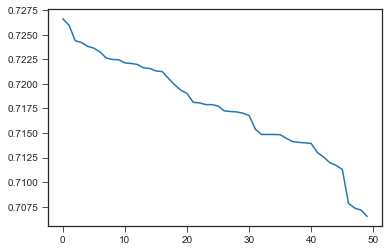

In [29]:
# Zobaczmy jak wyglądają wyniki od najlepszego graficznie
plt.plot([x for x, y in sorted(results, key=lambda x: x[0], reverse=True)])

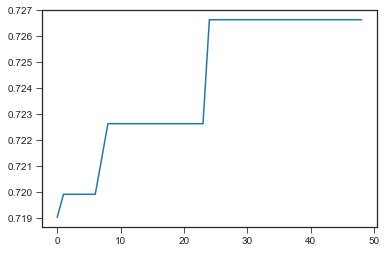

In [30]:
# Możemy tez zobaczyć jak z czasem poprawiał się najlepszy wynik:
bestHistory = []
for k in range(1,len(results)):
    # List comprehension: dla k pierwszych wartości zwróć maximum
    bestHistory.append(np.max([x for x, y in sorted(results[:k], key=lambda x: x[0], reverse=True)]))
# Wykres historii
plt.plot(bestHistory)

Zapisuję wyniki

In [36]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=9,
                                                                    max_features=2,
                                                                    min_samples_split=15, min_samples_leaf=14)
print(np.mean(testResults))

modelRF_rs = {
    "name":"RF_rs",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=1000, max_depth=9, max_features=2, min_samples_split=15, min_samples_leaf=14',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7277456746116572


Taki sam wynik co iteracyjnie.

In [35]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1_ver2_rs.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF_rs, fp)